In [14]:
import pickle
import sys

import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import multilabel_confusion_matrix

sys.path.append('../src/')
from config import *

### Load Data

In [15]:
label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = pd.read_csv(f'../{data_file}')[label_names].to_numpy()

with open(f'../{pca_result_file}', 'rb') as file:
    X = pickle.load(file)

In [16]:
#n = 10000
#X = X[:n, :]
#y = y[:n, :]
y.shape

(159571, 6)

In [17]:
#samples_per_label = y.sum(axis=0)
#imbalance_ratios_per_label = samples_per_label / len(y)

#class_weights = [{0:imbalance_ratios_per_label[i], 1:1} for i in range(y.shape[1])]
#class_weights = {i : 1/imbalance_ratios_per_label[i] for i in range(y.shape[1])}

In [18]:
# Split the data into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [40]:
np.set_printoptions(threshold=np.inf, edgeitems=6)
print(np.round(X_train[0:20], decimals=3))

[[0.347 0.335 0.38  0.363 0.4   0.253 0.381 0.384 0.445 0.315 0.472 0.55  0.356 0.441 0.345 0.491 0.445 0.464 0.515 0.609 0.535 0.348 0.529 0.642 0.412 0.512 0.538 0.516 0.364 0.345 0.47  0.351 0.64  0.422 0.363 0.332 0.531 0.557 0.478 0.508 0.411 0.537 0.386 0.496 0.481 0.544 0.482 0.488 0.492 0.446 0.522 0.45  0.429 0.44  0.486 0.464 0.44  0.458 0.488 0.404 0.506 0.348 0.524 0.461 0.526 0.393 0.477 0.462 0.494 0.363 0.449 0.433 0.528 0.4   0.528 0.429 0.364 0.416 0.43  0.492 0.519 0.413 0.568 0.59  0.361 0.578 0.453 0.565 0.492 0.424 0.474 0.426 0.464 0.4   0.409 0.382 0.45  0.49  0.417 0.369 0.467 0.333 0.399 0.285 0.485 0.295 0.29  0.405 0.476 0.365 0.471 0.484 0.389 0.554 0.452 0.469 0.391 0.327 0.37  0.435 0.479 0.561 0.316 0.488 0.438 0.493 0.425 0.41  0.426 0.405 0.402 0.465 0.325 0.254 0.432 0.4   0.226 0.419 0.469 0.363 0.461 0.289 0.31  0.478 0.408 0.493 0.376 0.377 0.47  0.489 0.388 0.369 0.448 0.494 0.335 0.487 0.416 0.335 0.469 0.512 0.494 0.361 0.539 0.367 0.438 0.333 0.

### Model training

In [6]:
def auc_eval(preds, dmatrix):
    labels = np.reshape(dmatrix.get_label(), preds.shape)

    # auc
    # roc_auc_scores = [roc_auc_score(labels[:, i], preds[:, i]) for i in range(labels.shape[1])]
    # auc = np.mean(roc_auc_scores)
    auc = roc_auc_score(labels, preds, average='weighted')
    
    # f1
    preds_bin = np.round(preds).astype(int)
    f1 = f1_score(preds_bin, labels, average='weighted')

    return [('auc', auc), ('f1_score', f1)] 

In [7]:
# Convert matrix to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# Set up XGBoost parameters
params = {
    'device': 'cuda',
    'objective': objective,
    'eval_metric': eval_metric,
    'alpha': alpha,     
    'gamma': gamma,
    'eta': eta,
    'max_depth': max_depth,
    'subsample': subsample,
    'colsample_bytree': colsample_bytree,
    'scale_pos_weight': scale_pos_weight,
    'min_child_weight': min_child_weight,
    'seed': random_state
}

evals_result = {}

# Train the XGBoost model
model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=[(dtrain, 'train'), (dvalid, 'val')],
    evals_result=evals_result,
    early_stopping_rounds=400,
    custom_metric=auc_eval,
    maximize=False,
    verbose_eval = 10
)

[0]	train-error:0.03668	train-auc:0.75321	train-f1_score:0.00000	val-error:0.03656	val-auc:0.75067	val-f1_score:0.00000
[10]	train-error:0.03466	train-auc:0.87543	train-f1_score:0.16907	val-error:0.03450	val-auc:0.86578	val-f1_score:0.16877
[20]	train-error:0.03191	train-auc:0.89855	train-f1_score:0.27089	val-error:0.03179	val-auc:0.88778	val-f1_score:0.27667
[30]	train-error:0.02980	train-auc:0.91175	train-f1_score:0.34394	val-error:0.03001	val-auc:0.89941	val-f1_score:0.34260
[40]	train-error:0.02817	train-auc:0.92409	train-f1_score:0.39946	val-error:0.02852	val-auc:0.91129	val-f1_score:0.39800
[50]	train-error:0.02666	train-auc:0.93277	train-f1_score:0.44883	val-error:0.02717	val-auc:0.91927	val-f1_score:0.44293
[60]	train-error:0.02557	train-auc:0.93943	train-f1_score:0.48532	val-error:0.02622	val-auc:0.92437	val-f1_score:0.47647
[70]	train-error:0.02459	train-auc:0.94531	train-f1_score:0.51641	val-error:0.02548	val-auc:0.92917	val-f1_score:0.50226
[80]	train-error:0.02372	train-au

In [13]:
model.save_model(f'../{xgb_model}-v{xgb_model_version}.json') 

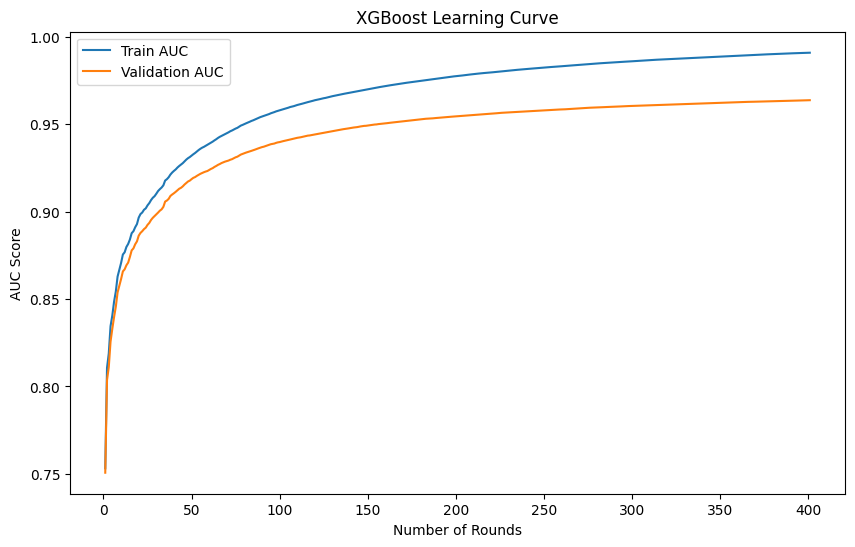

In [9]:
# Plot ROC AUC learning curve
train_auc = evals_result['train']['auc']
valid_auc = evals_result['val']['auc']

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_auc) + 1), train_auc, label='Train AUC')
plt.plot(range(1, len(valid_auc) + 1), valid_auc, label='Validation AUC')
plt.xlabel('Number of Rounds')
plt.ylabel('AUC Score')
plt.title('XGBoost Learning Curve')
plt.legend()
plt.show()

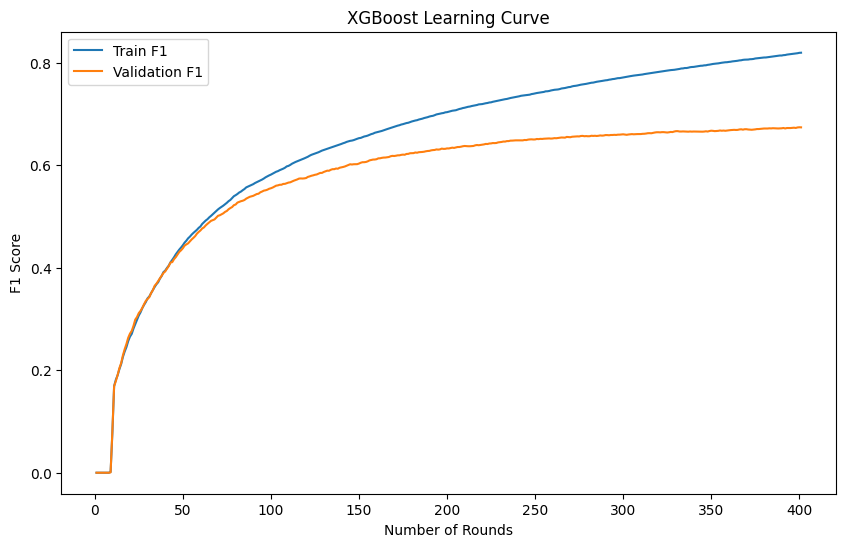

In [10]:
# Plot f1 score learning curve
train_auc = evals_result['train']['f1_score']
valid_auc = evals_result['val']['f1_score']

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_auc) + 1), train_auc, label='Train F1')
plt.plot(range(1, len(valid_auc) + 1), valid_auc, label='Validation F1')
plt.xlabel('Number of Rounds')
plt.ylabel('F1 Score')
plt.title('XGBoost Learning Curve')
plt.legend()
plt.show()

# Make predictions on the test set
y_pred = model.predict(dvalid)
y_pred_bin = np.round(y_pred).astype(int)

Confusion Matrix for Target toxic:


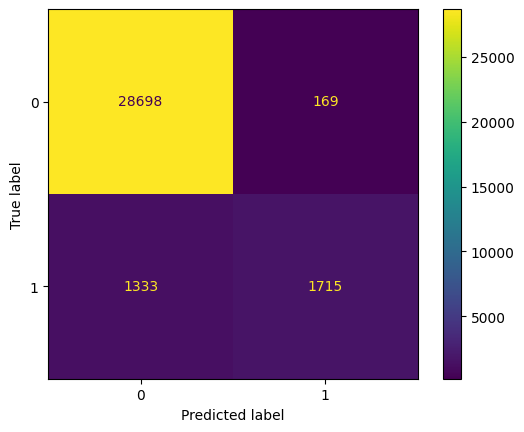

Confusion Matrix for Target severe_toxic:


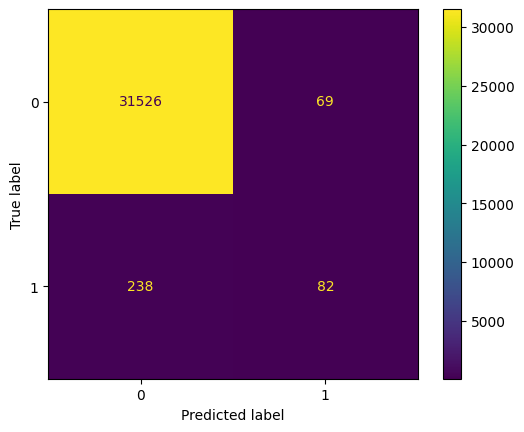

Confusion Matrix for Target obscene:


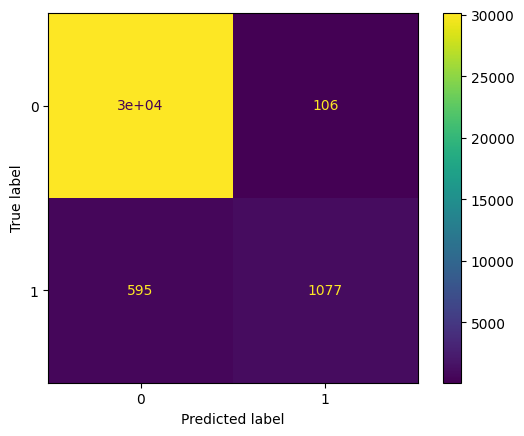

Confusion Matrix for Target threat:


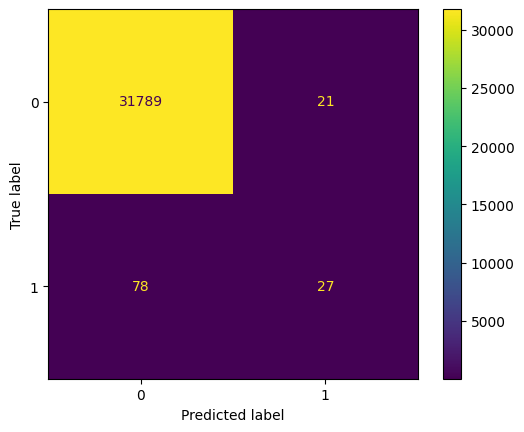

Confusion Matrix for Target insult:


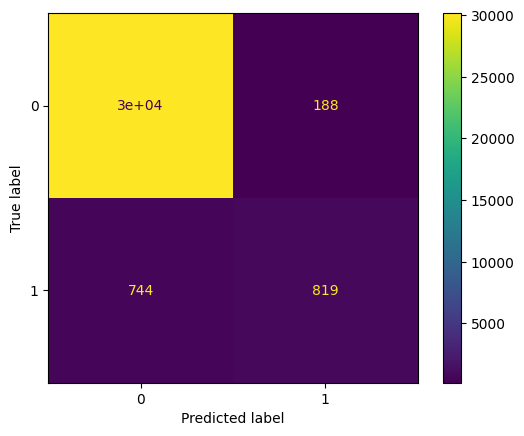

Confusion Matrix for Target identity_hate:


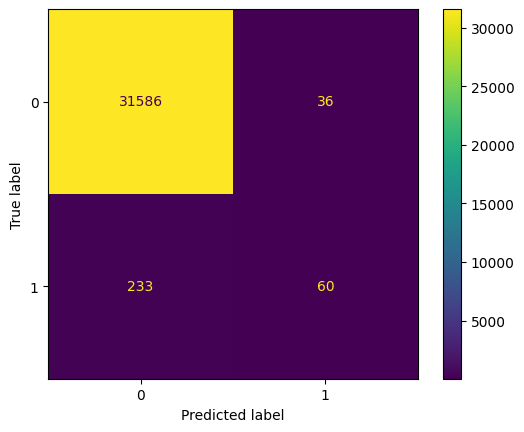

In [11]:
# Draw confusion matrix
conf_matrix = multilabel_confusion_matrix(y_valid, y_pred_bin)

# Print or inspect the confusion matrix for each target
for i, matrix in enumerate(conf_matrix):
    print(f"Confusion Matrix for Target {label_names[i]}:")
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot()
    plt.show()

In [12]:
df_model = pd.DataFrame(index=[0], columns=['Accuracy', 'Precision', 'Recall', 'F1'])

df_model['Accuracy'] = accuracy_score(y_valid, y_pred_bin)

df_model['Precision'] = precision_score(y_valid, y_pred_bin, average='weighted')

df_model['Recall'] = recall_score(y_valid, y_pred_bin, average='weighted')

df_model['F1'] = f1_score(y_valid, y_pred_bin, average='weighted')

roc_auc_scores = [roc_auc_score(y_valid[:, i], y_pred[:, i]) for i in range(y_valid.shape[1])]
df_model['AUC'] = np.mean(roc_auc_scores)

df_model

,Accuracy,Precision,Recall,F1,AUC
0,0.917249,0.854725,0.539923,0.659374,0.969175


### Evaluate